<a href="https://colab.research.google.com/github/tsoares36/MVP1/blob/main/MVP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Objetivo do MVP**

**Descrição do problema:** verificar o valor das ações da Tesla em comparação com a fabricação de carros elétricos e híbridos, desta empresa, durante o período de 2020 a 2023, nos EUA. O escopo pode ser extrapolado para, a partir desses dados, obter um valor projetado das ações da companhia para os anos seguintes - 2024 e 2025, bem como a produção de carros para esses períodos (modelo de regressão)



**Tipo de problema:** como o objetivo inicial do MVP é verificar a correlação entre a variação do preço das ações em função da fabricação de carros elétricos da Tesla, um modelo de regressão poderia ser mais apropriado.

**Premissas ou hipóteses:** a hipótese mais fundamental é de que a quantidade fabricada (e, consequentemente, vendida) influencia diretamente nos preços das ações, entretanto, como trata-se de tecnologia nova, muito do valor desses papéis pode ser apenas especulativo.

**Metodologia:** dois datasets da plataforma Kaggle foram utilizados: uma base de dados com carros elétricos produzidos nos EUA, desde 1997 a 2023 e outro com o preço das ações da Tesla, no período de 2020 a 2023. Para fins de manutenção da comparabilidade, o escopo foi reduzido ao quadriênio 2020-2023. Esses datasets foram colocados num repositório público do GitHub e lidos diretamente neste notebook.

**Restrições:** não há valores nem datas das vendas dos automóveis, apenas as datas de fabricação por modelo. Existe, entretanto, uma coluna de valor sugerido de venda que contém vários dados com valor zero. Essa coluna tem alguns dados duplicados para alguns carros e zerados para outros. A solução encontrada foi criar um dataframe com valores exclusivos, por modelo de carro, completando os valores zerados com o valor mediano do preço de venda sugerido e concatenar com o dataframe original, preenchendo assim as lacunas.

**Extra:** Foi desenvolvido também um aplicativo simples utilizando a biblioteca Streamlit do Python para visualização de dados. O deploy da aplicação foi realizado em https://tsoares36-mvp3-stapp-2ghsd9.streamlit.app/

# Importação das bibliotecas

In [286]:
# Packages for EDA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer

# from datasist.structdata import detect_outliers
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# import category_encoders as ce
import re

# Modeling and evaluation
# from sklearn.experimental import enable_hist_gradient_boosting
# from sklearn.ensemble import (
#    BaggingClassifier,
#    ExtraTreesClassifier,
#    RandomForestClassifier,
#    StackingClassifier,
#    HistGradientBoostingClassifier
#)
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_classification

# Packages options
sns.set(rc={'figure.figsize': [14, 7]}, font_scale=1.2) # Standard figure size for all
np.seterr(divide='ignore', invalid='ignore', over='ignore') ;

# Unbalanced data improviment
from imblearn.over_sampling import SMOTE

# Save the trained model
import warnings
warnings.filterwarnings("ignore")

# **Leitura dos datasets**

In [287]:
git_main_dir = "https://raw.githubusercontent.com/tsoares36/MVP3/main/mvp_files/"

dataset_stock_url = f"{git_main_dir}tesla_stock_data.csv"

# ler dataset de ações da Tesla
df_stock = pd.read_csv(dataset_stock_url)

# o arquivo do dataset de veículos era superior ao tamanho aceito no github
# foi dividido em 4 arquivos

dfs = []

# concatenar arquivos
[dfs.append(pd.read_csv(f'{git_main_dir}Electric_Vehicle_Population_Data_{n}.csv', sep=",")) for n in range(4)]

# adicionar colunas
for n in range(1, 4):
  dfs[n].columns = dfs[0].columns

df_electric_car = pd.concat(dfs, axis=0, ignore_index=True)

## Análise de dados

In [288]:
# exibir primeiras linhas do dataframe (Tesla stocks)

df_stock.head()

,Date,Year,Open,High,Low,Close,Volume,Adj Close
0,2020-01-02,2020,28.299999,28.713333,28.114000,28.684000,142981500,28.684000
1,2020-01-03,2020,29.366667,30.266666,29.128000,29.534000,266677500,29.534000
2,2020-01-06,2020,29.364668,30.104000,29.333332,30.102667,151995000,30.102667
3,2020-01-07,2020,30.760000,31.441999,30.224001,31.270666,268231500,31.270666
4,2020-01-08,2020,31.580000,33.232666,31.215334,32.809334,467164500,32.809334


In [289]:
# exibir últimas linhas do dataframe (Tesla stocks)

df_stock.tail()

,Date,Year,Open,High,Low,Close,Volume,Adj Close
991,2023-12-22,2023,256.760010,258.220001,251.369995,252.539993,93249800,252.539993
992,2023-12-26,2023,254.490005,257.970001,252.910004,256.609985,86892400,256.609985
993,2023-12-27,2023,258.350006,263.339996,257.519989,261.440002,106494400,261.440002
994,2023-12-28,2023,263.660004,265.130005,252.710007,253.179993,113619900,253.179993
995,2023-12-29,2023,255.100006,255.190002,247.429993,248.479996,100615300,248.479996


In [290]:
# informações sobre o dataframe

df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       996 non-null    object 
 1   Year       996 non-null    int64  
 2   Open       996 non-null    float64
 3   High       996 non-null    float64
 4   Low        996 non-null    float64
 5   Close      996 non-null    float64
 6   Volume     996 non-null    int64  
 7   Adj Close  996 non-null    float64
dtypes: float64(5), int64(2), object(1)
memory usage: 62.4+ KB


In [291]:
# obter estatísticas do dataset

df_stock.describe()

,Year,Open,High,Low,Close,Volume,Adj Close
count,996.000000,996.000000,996.000000,996.000000,996.000000,9.960000e+02,996.000000
mean,2021.493976,209.203720,213.956547,204.062843,209.121335,1.335149e+08,209.121335
std,1.118579,85.884404,87.588506,83.894602,85.708640,8.888939e+07,85.708640
min,2020.000000,24.980000,26.990667,23.367332,24.081333,2.940180e+07,24.081333
25%,2020.000000,159.780838,162.617496,154.389996,160.250004,7.718922e+07,160.250004
50%,2021.000000,223.989998,229.250000,218.266663,223.651665,1.074158e+08,223.651665
75%,2022.000000,263.002510,268.010002,258.120010,262.667496,1.578296e+08,262.667496
max,2023.000000,411.470001,414.496674,405.666656,409.970001,9.140820e+08,409.970001


In [292]:
# média dos valores de abertura, máxima, mínima, fechamento e ajustado

df_stock['mean_value'] = (df_stock['Open'] + df_stock['High'] + df_stock['Low'] + df_stock['Close'] + df_stock['Adj Close']) / 5

df_stock.head()

,Date,Year,Open,High,Low,Close,Volume,Adj Close,mean_value
0,2020-01-02,2020,28.299999,28.713333,28.114000,28.684000,142981500,28.684000,28.499067
1,2020-01-03,2020,29.366667,30.266666,29.128000,29.534000,266677500,29.534000,29.565867
2,2020-01-06,2020,29.364668,30.104000,29.333332,30.102667,151995000,30.102667,29.801467
3,2020-01-07,2020,30.760000,31.441999,30.224001,31.270666,268231500,31.270666,30.993467
4,2020-01-08,2020,31.580000,33.232666,31.215334,32.809334,467164500,32.809334,32.329333


In [293]:
# verificar valores nulos

df_stock.isnull().sum()

,0
Date,0
Year,0
Open,0
High,0
Low,0
Close,0
Volume,0
Adj Close,0
mean_value,0


**Colunas do dataframe df_stock e seus respectivos significados:**

'Date' -> data completa da cotação da ação

'Year' -> ano de referência da cotação

'Open' -> preço de abertura da ação, no dia

'High' -> máxima da ação naquele dia

'Low' -> mínima da ação naquele dia

'Close' -> preço de fechamento da ação no mercado do dia

'Volume' -> número de ações negociadas no dia

'Adj Close' -> preço de fechamento ajustado

In [294]:
# exibir as primeiras linhas do dataframe de carros elétricos
# este dataset contém modelos de carros elétricos fabricados nos EUA de várias marcas

df_electric_car.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,1C4RJXN66R,Snohomish,Everett,WA,98204.0,2024,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,21.0,0.0,21.0,261311557,POINT (-122.2507211 47.8976713),PUGET SOUND ENERGY INC,5.306104e+10
1,KNDJX3AEXG,King,Renton,WA,98058.0,2016,KIA,SOUL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,93.0,31950.0,11.0,210641315,POINT (-122.1476337 47.4438471),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10
2,5YJ3E1EA3L,King,Seattle,WA,98125.0,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,266.0,0.0,46.0,124517347,POINT (-122.304356 47.715668),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303300e+10
3,1G1RC6S5XH,Kitsap,Port Orchard,WA,98367.0,2017,CHEVROLET,VOLT,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,53.0,0.0,26.0,7832933,POINT (-122.6530052 47.4739066),PUGET SOUND ENERGY INC,5.303509e+10
4,5UXTA6C09P,Snohomish,Monroe,WA,98272.0,2023,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,30.0,0.0,39.0,235249262,POINT (-121.968385 47.854897),PUGET SOUND ENERGY INC,5.306105e+10


In [295]:
# últimas linhas do dataframe

df_electric_car.tail()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
194227,5YJYGDEE1M,Franklin,Pasco,WA,99301.0,2021,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,9.0,179707937,POINT (-119.1429639 46.2546529),BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF F...,5.302102e+10
194228,5YJ3E1EA7P,Clallam,Sequim,WA,98382.0,2023,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,24.0,241584416,POINT (-123.1090862 48.0805816),BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF C...,5.300900e+10
194229,5YJ3E1EB6P,Snohomish,Everett,WA,98208.0,2023,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,38.0,249701056,POINT (-122.2032349 47.8956271),PUGET SOUND ENERGY INC,5.306104e+10
194230,5YJ3E1EA5K,King,Issaquah,WA,98029.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220.0,0.0,5.0,106197619,POINT (-122.0209893 47.5632565),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10
194231,5YJ3E1EB7K,Snohomish,Edmonds,WA,98020.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220.0,0.0,32.0,476805052,POINT (-122.3757836 47.800042),PUGET SOUND ENERGY INC,5.306105e+10


In [296]:
df_electric_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194232 entries, 0 to 194231
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         194232 non-null  object 
 1   County                                             194223 non-null  object 
 2   City                                               194223 non-null  object 
 3   State                                              194232 non-null  object 
 4   Postal Code                                        194223 non-null  float64
 5   Model Year                                         194232 non-null  int64  
 6   Make                                               194232 non-null  object 
 7   Model                                              194232 non-null  object 
 8   Electric Vehicle Type                              194232 non-null  object

**Colunas do dataframe "df_electric_car" e seus respectivos significados**

'VIN (1-10)' -> Vehicle Identification Number: é um tipo de código que permite identificar o país em que foi fabricado, a motorização, o tipo de carroceria etc.

'County' -> Condado ou distrito em que o carro foi fabricado

'City' -> Cidade em que o veículo foi produzido

'State' -> Estado no qual o veículo foi fabricado

'Postal Code' -> Código postal do local (CEP)

'Model Year' -> Ano de referência do modelo fabricado

'Make' -> Empresa que fabricou o veículo

'Model' -> Modelo ou nome do carro

'Electric Vehicle Type' -> Tipo de veículo elétrico

'Clean Alternative Fuel Vehicle (CAFV) Eligibility' -> veículos que utilizam combustíveis alternativos que emitem menos poluentes em comparação aos combustíveis tradicionais, como gasolina ou diesel

'Electric Range' -> autonomia do veículo com uso apenas da bateria, geralmente dada em quilômetros

'Base MSRP' -> preço de venda sugerido pelo fabricante.

'Legislative District' -> subdivisão geográfica dos estados americanos

'DOL Vehicle ID' -> identificação exclusiva concedida pelo departamenteo de trânsito

'Vehicle Location' -> localização precisa do veículo, latitude e longitude

'Electric Utility' -> empresa fornecedora de energia elétrica em cada região

'2020 Census Tract' -> pequenas áreas relativamente permanentes, desenhadas para refletir características populacionais e econômicas de uma determinada região (neste caso, em 2020)

**Um pouco mais sobre os dados**

Os dataframes são, até certo ponto, complementares. No primeiro, df_stocks, temos as cotações diárias das ações da Tesla e, no segundo, df_electric_car, dados gerais sobre carros de diversas marcas.

Os dados que interessam desse segundo dataframe são os carros produzidos pela Tesla e o 'Base MSRP', que corresponde ao preço de venda sugerido por cada fabricante. Conforme mencionado, para diminuir essa quantidade de zeros, criou-se outro dataframe apenas com os valores exclusivos para cada modelo de carro, posteriormente, os valores zerados foram completados com os valores medianos (que são menos suscetíveis aos extremos) e, enfim, concatenar esse dataframe auxiliar com o principal (df_electric_car). O filtro abaixo mostra a contagem de valores vazios no campo em questão, para o fabricante "TELSA"

In [297]:
df_electric_car[(df_electric_car['Make'] == 'TESLA') & (df_electric_car['Base MSRP'] == 0.0)].count()

,0
VIN (1-10),83786
County,83781
City,83781
State,83786
Postal Code,83781
Model Year,83786
Make,83786
Model,83786
Electric Vehicle Type,83786
Clean Alternative Fuel Vehicle (CAFV) Eligibility,83786


O dataframe de ações (df_stock) está com dados bem coerentes, a única observação talvez seja que a série histórica não é muito extensa, 4 anos com 996 observações.

In [298]:
df_stock.groupby('Year').describe()

Open                                                             \
      count        mean        std         min         25%         50%   
Year                                                                     
2020  251.0   96.441413  55.928133   24.980000   49.461334   81.431999   
2021  249.0  259.591299  53.096508  184.183334  223.333328  239.933334   
2022  249.0  264.025288  58.066215  110.349998  224.509995  272.679993   
2023  247.0  217.731093  41.899387  103.000000  186.614998  224.220001   

                               High              ...   Adj Close              \
             75%         max  count        mean  ...         75%         max   
Year                                             ...                           
2020  140.538330  233.330002  251.0   99.167559  ...  140.409996  235.223328   
2021  283.929993  411.470001  249.0  264.906920  ...  283.153320  409.970001   
2022  301.829987  396.516663  249.0  270.456185  ...  302.609985  399.926666   
2023  251.969994  296.040009  247.0  222.284413  ...  253.339996  293.339996   

     mean_value                                                             \
          count        mean        std         min         25%         50%   
Year                                                                         
2020      251.0   96.535848  56.048481   24.890800   49.871001   80.698666   
2021      249.0  259.544830  53.058233  186.177335  223.120001  242.389999   
2022      249.0  263.365979  57.854663  112.055998  225.530002  271.765991   
2023      247.0  217.900785  41.648793  109.063998  187.106999  222.712000   

                              
             75%         max  
Year                          
2020  140.629996  234.744666  
2021  282.993329  410.314667  
2022  303.316003  392.294666  
2023  252.583000  293.474005  

[4 rows x 56 columns]

##Limpeza e visualização de dados

In [299]:
# obtendo tabela de preços sugeridos dos carros

df_precos = df_electric_car[['Model', 'Base MSRP']].drop_duplicates()
df_precos

,Model,Base MSRP
0,WRANGLER,0.0
1,SOUL,31950.0
2,MODEL 3,0.0
3,VOLT,0.0
4,X5,0.0
...,...,...
122090,BENTAYGA,0.0
130724,918,845000.0
142694,ESPRINTER,0.0
144218,745LE,0.0


In [300]:
# Substituir valores 0 por NaN para calcular a mediana corretamente
df_precos['Base MSRP'].replace(0.0, np.nan, inplace=True)

# Calcular a mediana dos valores não nulos
median_price = df_precos['Base MSRP'].median()

# Preencher os valores NaN com a mediana
df_precos['Base MSRP'].fillna(median_price, inplace=True)

# imprimir o dataframe após transformações
df_precos

,Model,Base MSRP
0,WRANGLER,55325.0
1,SOUL,31950.0
2,MODEL 3,55325.0
3,VOLT,55325.0
4,X5,55325.0
...,...,...
122090,BENTAYGA,55325.0
130724,918,845000.0
142694,ESPRINTER,55325.0
144218,745LE,55325.0


In [301]:
df_precos['Base MSRP'].sum()

10777255.0

In [302]:
# concatenr df_electric_car com df_precos tendo como chave a coluna Model

df_electric_car = pd.merge(df_electric_car, df_precos, on='Model', how='left', suffixes=('', '_y'))
df_electric_car = df_electric_car.loc[:,~df_electric_car.columns.duplicated()]
df_electric_car.drop(columns=['Base MSRP'], inplace=True)
df_electric_car.rename(columns={'Base MSRP_y': 'Base MSRP'}, inplace=True)

In [303]:
df_electric_car.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract,Base MSRP
0,1C4RJXN66R,Snohomish,Everett,WA,98204.0,2024,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,21.0,21.0,261311557,POINT (-122.2507211 47.8976713),PUGET SOUND ENERGY INC,5.306104e+10,55325.0
1,KNDJX3AEXG,King,Renton,WA,98058.0,2016,KIA,SOUL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,93.0,11.0,210641315,POINT (-122.1476337 47.4438471),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10,31950.0
2,KNDJX3AEXG,King,Renton,WA,98058.0,2016,KIA,SOUL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,93.0,11.0,210641315,POINT (-122.1476337 47.4438471),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10,55325.0
3,5YJ3E1EA3L,King,Seattle,WA,98125.0,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,266.0,46.0,124517347,POINT (-122.304356 47.715668),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303300e+10,55325.0
4,1G1RC6S5XH,Kitsap,Port Orchard,WA,98367.0,2017,CHEVROLET,VOLT,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,53.0,26.0,7832933,POINT (-122.6530052 47.4739066),PUGET SOUND ENERGY INC,5.303509e+10,55325.0


In [304]:
# retirar colunas desnecessárias (df_electric_car)
df_electric_car = df_electric_car.drop(
    ['Postal Code', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Legislative District', 'DOL Vehicle ID', 'Electric Utility', '2020 Census Tract'], axis = 1)

# remover parênteses
df_electric_car['Vehicle Location'] = df_electric_car['Vehicle Location'].str.replace(r'[()]', '', regex=True)

# separar colunas - latitude/longitude
df_electric_car[['point', 'Latitude', 'Longitude']] = df_electric_car["Vehicle Location"].str.split(" ", expand = True)

# remover texto antes do número
df_electric_car.drop(columns=['Vehicle Location', 'point'], inplace=True)

# converter latitude/longitude para número do tipo float
df_electric_car[['Latitude', 'Longitude']] = df_electric_car[['Latitude', 'Longitude']].astype(float)

In [305]:
df_electric_car.head()

,VIN (1-10),County,City,State,Model Year,Make,Model,Electric Vehicle Type,Electric Range,Base MSRP,Latitude,Longitude
0,1C4RJXN66R,Snohomish,Everett,WA,2024,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),21.0,55325.0,-122.250721,47.897671
1,KNDJX3AEXG,King,Renton,WA,2016,KIA,SOUL,Battery Electric Vehicle (BEV),93.0,31950.0,-122.147634,47.443847
2,KNDJX3AEXG,King,Renton,WA,2016,KIA,SOUL,Battery Electric Vehicle (BEV),93.0,55325.0,-122.147634,47.443847
3,5YJ3E1EA3L,King,Seattle,WA,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),266.0,55325.0,-122.304356,47.715668
4,1G1RC6S5XH,Kitsap,Port Orchard,WA,2017,CHEVROLET,VOLT,Plug-in Hybrid Electric Vehicle (PHEV),53.0,55325.0,-122.653005,47.473907


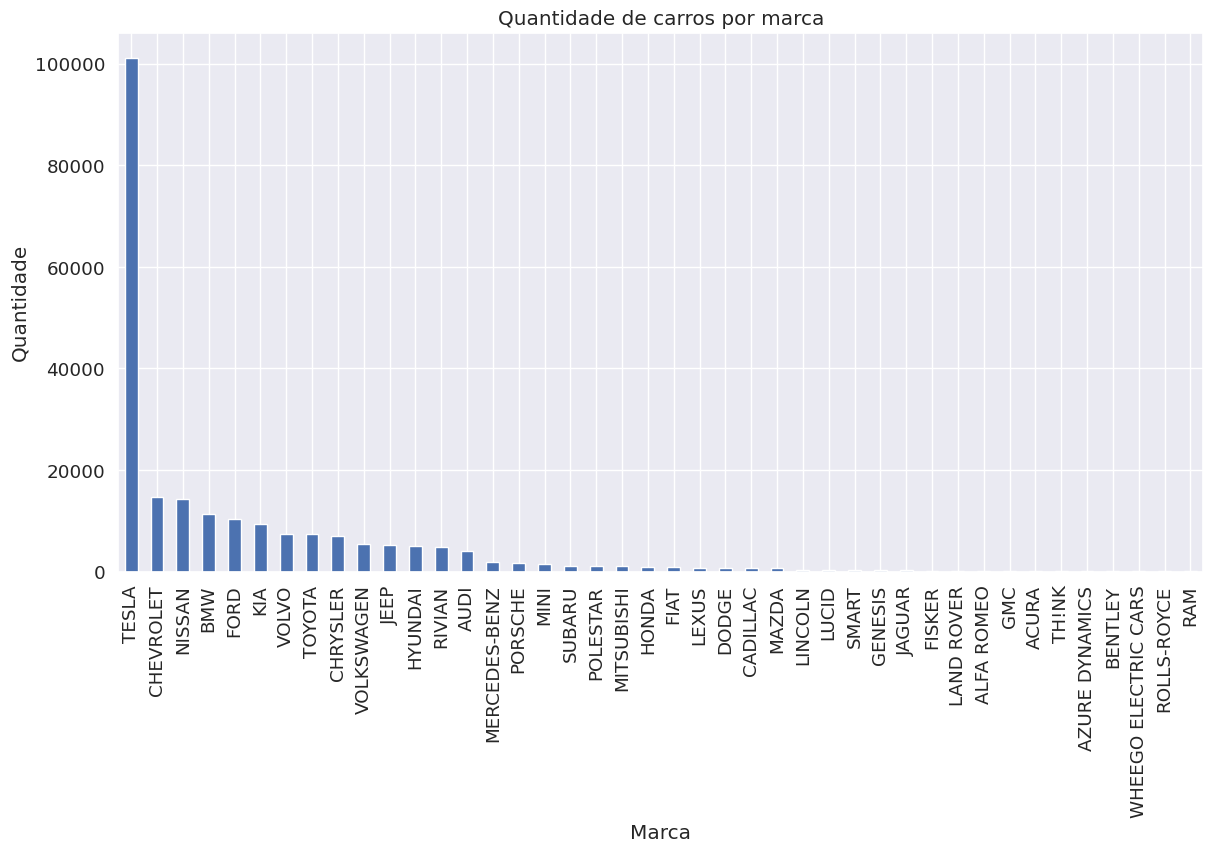

In [306]:
# quantidade de carros de cada marca (Make)

df_electric_car['Make'].value_counts().plot(kind='bar')
plt.title('Quantidade de carros por marca')
plt.xlabel('Marca')
plt.ylabel('Quantidade')
plt.show()

In [307]:
# descrição do dataframe de carros elétricos

df_electric_car.describe()

,Model Year,Electric Range,Base MSRP,Latitude,Longitude
count,221227.000000,221223.000000,221227.000000,221207.000000,221207.000000
mean,2020.523462,62.028175,55789.877547,-122.021250,47.436842
std,3.115932,93.763350,5741.764353,1.811816,0.824473
min,1997.000000,0.000000,31950.000000,-159.712613,20.735185
25%,2018.000000,0.000000,55325.000000,-122.395519,47.358111
50%,2022.000000,14.000000,55325.000000,-122.275332,47.610347
75%,2023.000000,84.000000,55325.000000,-122.136803,47.721052
max,2025.000000,337.000000,845000.000000,-70.743216,61.318822


In [308]:
# mostrar os valores null ou nan no dataframe df_electric_car

df_electric_car.isnull().sum()

,0
VIN (1-10),0
County,14
City,14
State,0
Model Year,0
Make,0
Model,0
Electric Vehicle Type,0
Electric Range,4
Base MSRP,0


In [309]:
anos_analisados = [2020, 2021, 2022, 2023]

In [310]:
# Retirar os valores null do dataframe df_electric_car

df_electric_car.dropna(inplace=True)

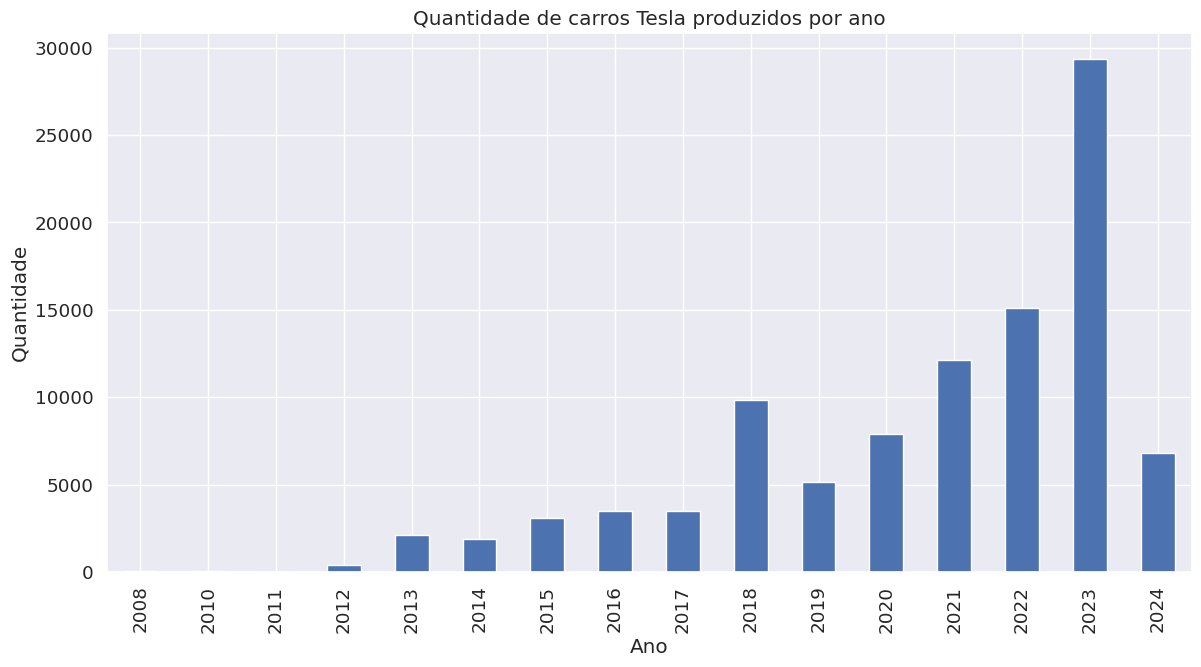

In [311]:
# quantidade de carros produzidos pela Tesla ao longo dos anos

# filtrar apenas carros da Tesla
tesla_cars = df_electric_car[df_electric_car['Make'] == 'TESLA']

# agrupar por ano e contar a quantidade de carros
tesla_cars_by_year = tesla_cars.groupby('Model Year')['VIN (1-10)'].count()

# plotar o gráfico
tesla_cars_by_year.plot(kind='bar')
plt.title('Quantidade de carros Tesla produzidos por ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade')
plt.show()


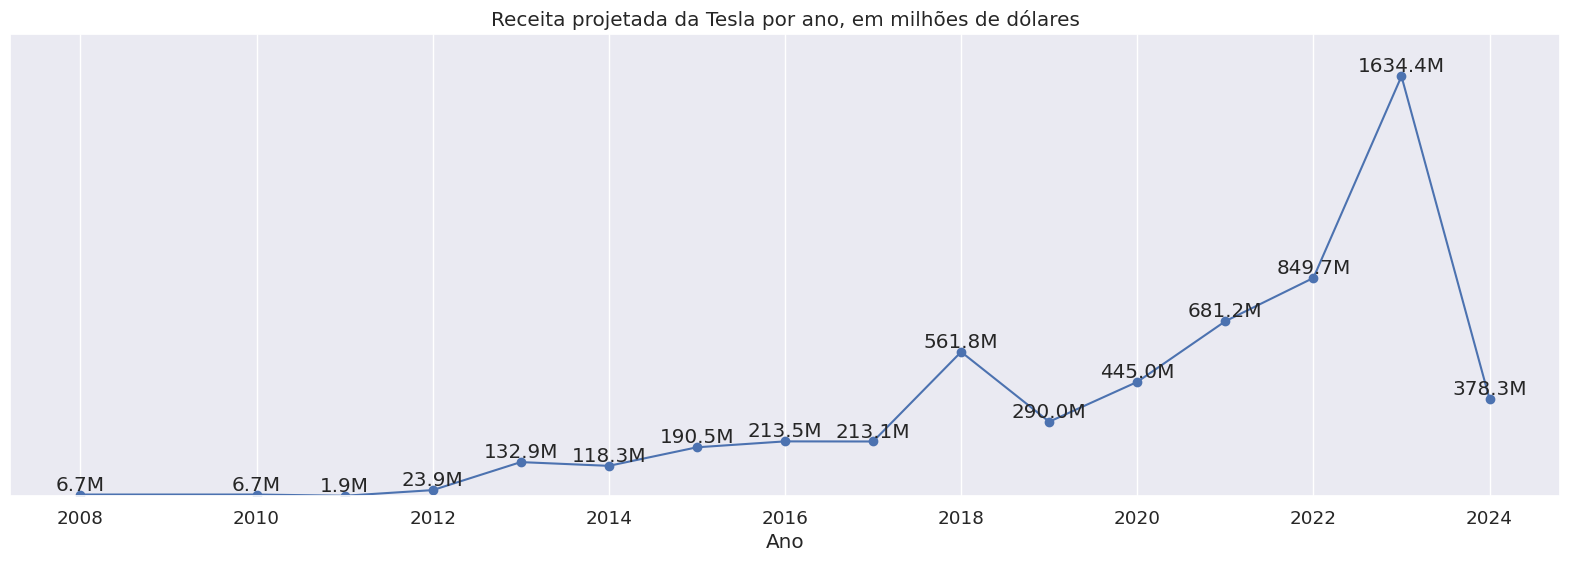

In [312]:
# considerando o preço sugerido de venda como uma venda provável, teríamos a seguinte receita de vendas projetada ao longo dos anos

# Agrupar e calcular as vendas por ano
tesla_car_sells_by_year = tesla_cars.groupby('Model Year')['Base MSRP'].sum()

tesla_car_sells_by_year_millions = tesla_car_sells_by_year / 1e6

# Plotar o gráfico
fig, ax = plt.subplots(figsize=(20,6))
tesla_car_sells_by_year.plot(kind='line')

ax.plot(tesla_car_sells_by_year_millions.index, tesla_car_sells_by_year_millions.values, marker='o', linestyle='-', color='b')

plt.ylim(0, tesla_car_sells_by_year_millions.max() * 1.1)

# Adicionar título e rótulos de eixo X
plt.title('Receita projetada da Tesla por ano, em milhões de dólares')
plt.xlabel('Ano')

# Remover o rótulo do eixo Y
plt.gca().axes.get_yaxis().set_visible(False)

# Adicionar rótulos de dados
for x, y in zip(tesla_car_sells_by_year.index, tesla_car_sells_by_year_millions.values):
    plt.text(x, y, f'{y:.1f}M', ha='center', va='bottom')

# Exibir o gráfico
plt.show()

In [313]:
tesla_car_sells_by_year

,Base MSRP
Model Year,
2008,6.696900e+06
2010,6.696900e+06
2011,1.913400e+06
2012,2.388112e+07
2013,1.329198e+08
2014,1.182949e+08
2015,1.904936e+08
2016,2.135302e+08
2017,2.130876e+08


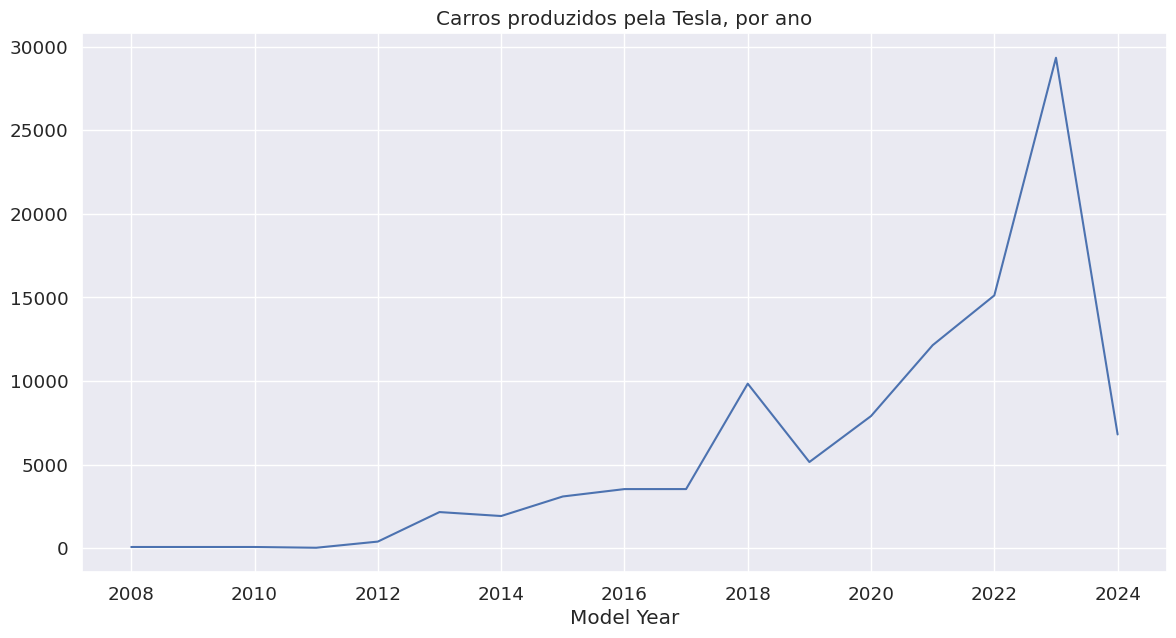

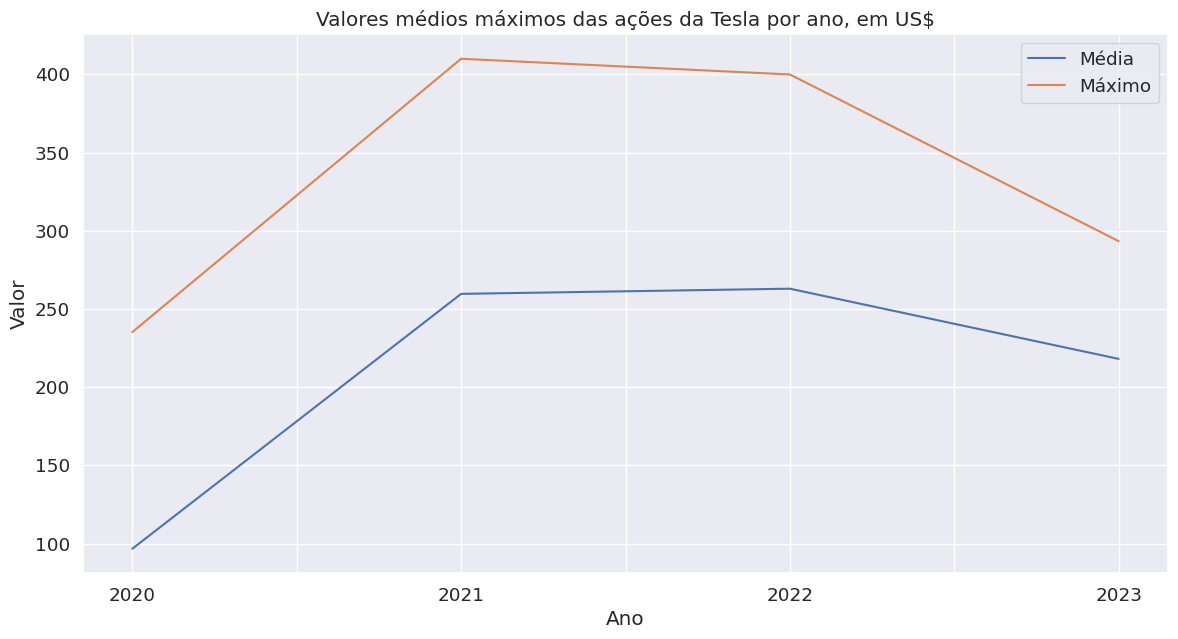

In [314]:
# Agrupar os dados por ano e calcular a média do preço de fechamento das ações

stock_by_year = df_stock.groupby(df_stock['Date'].str[:4])['Close'].mean()
stock_max_by_year = df_stock.groupby(df_stock['Date'].str[:4])['Close'].max()
producted_cars_by_year = tesla_cars_by_year.reset_index(name='Count')

# Plotar o gráfico
tesla_cars_by_year.plot(kind='line')
plt.title('Carros produzidos pela Tesla, por ano')
plt.show()

stock_by_year.plot(kind='line')
stock_max_by_year.plot(kind='line')

plt.legend(['Média', 'Máximo'])
plt.title('Valores médios máximos das ações da Tesla por ano, em US$')
plt.xlabel('Ano')
plt.ylabel('Valor')
plt.show()


# Limitar o escopo para que os dados fiquem no range de 2020 a 2023

In [315]:
# Limitando o escopo para que os dois dataframes fiquem com o mesmo 'range' (2020 a 2023)

tesla_cars_by_year = tesla_cars_by_year[tesla_cars_by_year.index.isin(anos_analisados)]
tesla_sells_by_year_ = tesla_car_sells_by_year[tesla_car_sells_by_year.index.isin(anos_analisados)]


In [316]:
tesla_cars_by_year

,VIN (1-10)
Model Year,
2020,7901
2021,12143
2022,15123
2023,29348


In [317]:
stock_by_year

,Close
Date,
2020,96.725601
2021,259.664552
2022,262.975582
2023,218.094453


In [318]:
tesla_sells_by_year_

,Base MSRP
Model Year,
2020,4.450318e+08
2021,6.811567e+08
2022,8.496637e+08
2023,1.634440e+09


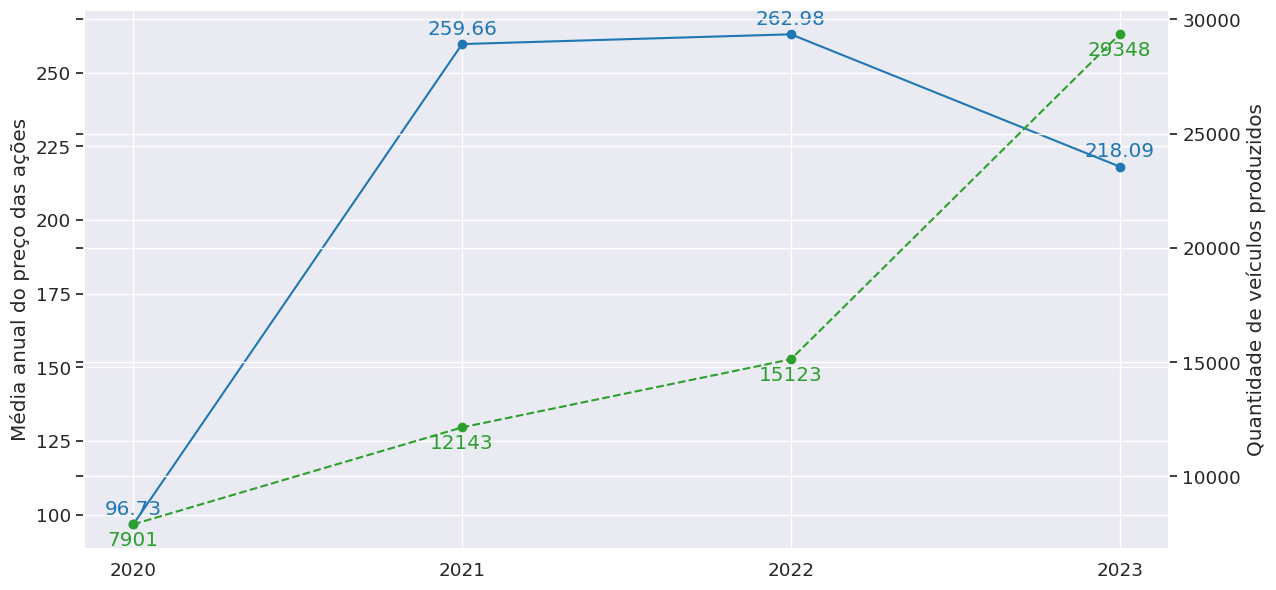

In [319]:
# gráfico para mostrar o preço médio das ações versus a quantidade produzida de veículos

fig, ax1 = plt.subplots()

carros_fabricados_por_ano = tesla_cars_by_year.to_list()
media_stocks_por_ano = stock_by_year.to_list()

# Plotando a primeira linha (média do valor das ações) no eixo Y da esquerda
ax1.plot(anos_analisados, media_stocks_por_ano, color='tab:blue', marker='o', label='Preço médio das ações')
ax1.tick_params(axis='y', which='both', left=True, right=True, labelleft=True)  # Esconde os valores do eixo Y esquerdo
ax1.set_ylabel('Média anual do preço das ações')

# Adicionando rótulos para o preço das ações
for i in range(len(anos_analisados)):
    ax1.annotate(f'{media_stocks_por_ano[i]:.2f}',
                 (anos_analisados[i], media_stocks_por_ano[i]),
                 textcoords="offset points",
                 xytext=(0, 7),
                 ha='center',
                 color='tab:blue')

# Criando um segundo eixo Y para a quantidade de carros fabricados
ax2 = ax1.twinx()
ax2.plot(anos_analisados, carros_fabricados_por_ano, color='tab:green', marker='o', linestyle='--')
ax2.set_ylabel('Quantidade de veículos produzidos')
ax2.tick_params(axis='y', which='both', left=True, right=True, labelright=True)

# Adicionando rótulos para a quantidade de carros fabricados
for i in range(len(anos_analisados)):
    ax2.annotate(f'{carros_fabricados_por_ano[i]}',
                 (anos_analisados[i], carros_fabricados_por_ano[i]),
                 textcoords="offset points",
                 xytext=(0,-15),
                 ha='center',
                 color='tab:green')

ax1.set_xticks(anos_analisados);
plt.show()

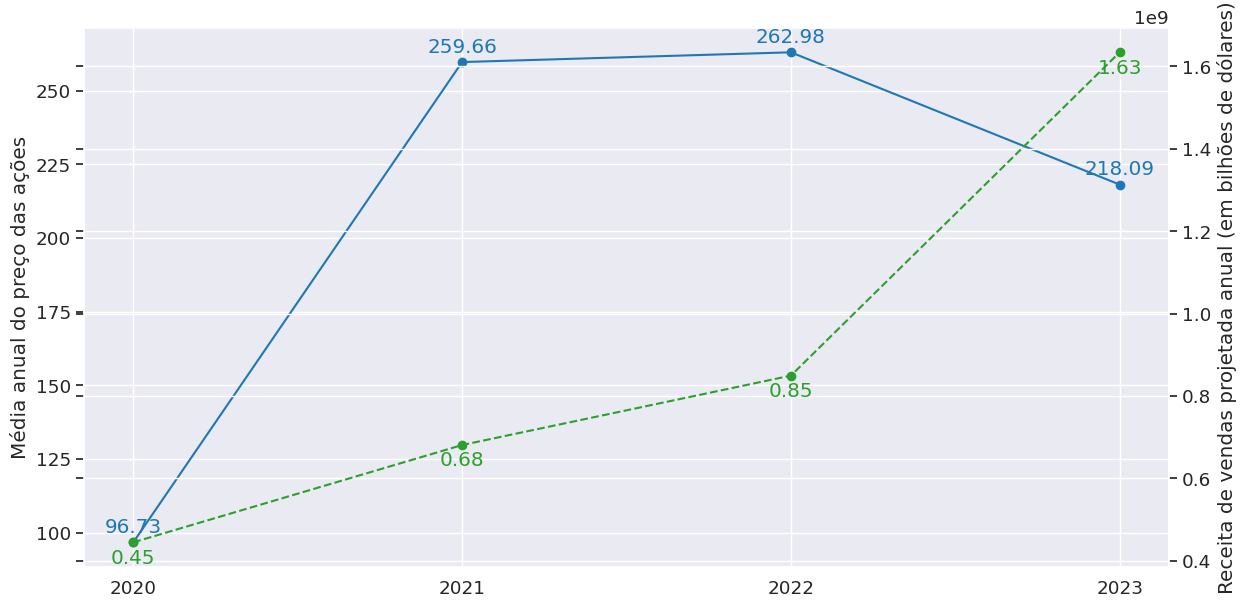

In [320]:
# gráfico para mostrar o preço das ações versus a receita de vendas 'projetada'

fig, ax1 = plt.subplots()

receita_projetada_anual = tesla_sells_by_year_.to_list()
media_stocks_por_ano = stock_by_year.to_list()

# Plotando a primeira linha (preço das ações) no eixo Y da esquerda
ax1.plot(anos_analisados, media_stocks_por_ano, color='tab:blue', marker='o', label='Carros Fabricados')
ax1.tick_params(axis='y', which='both', left=True, right=True, labelleft=True)  # Esconde os valores do eixo Y esquerdo
ax1.set_ylabel('Média anual do preço das ações')

# Adicionando rótulos para o preço médio das ações
for i in range(len(anos_analisados)):
    ax1.annotate(f'{media_stocks_por_ano[i]:.2f}',
                 (anos_analisados[i], media_stocks_por_ano[i]),
                 textcoords="offset points",
                 xytext=(0, 7),
                 ha='center',
                 color='tab:blue')

# Criando um segundo eixo Y para as vendas anuais projetadas
ax2 = ax1.twinx()
ax2.plot(anos_analisados, receita_projetada_anual, color='tab:green', marker='o', linestyle='--')
ax2.set_ylabel('Receita de vendas projetada anual (em bilhões de dólares)')
ax2.tick_params(axis='y', which='both', left=True, right=True, labelright=True)

# Adicionando rótulos para o valor das vendas anuais projetadas
for i in range(len(anos_analisados)):
    ax2.annotate(f'{round(receita_projetada_anual[i] / 1e9, 2)}',
                 (anos_analisados[i], receita_projetada_anual[i]),
                 textcoords="offset points",
                 xytext=(0,-15),
                 ha='center',
                 color='tab:green')

ax1.set_xticks(anos_analisados);
plt.show()

# Etapas adicionais para utilização de modelo simplificado de Regressão Linear

# **Pré-processamento**

In [321]:
tesla_cars_by_year = tesla_cars_by_year.reset_index()
tesla_sells_by_year_ = tesla_sells_by_year_.reset_index()
stock_by_year = stock_by_year.reset_index()

cars_and_stocks = pd.concat([tesla_cars_by_year, stock_by_year], axis=1).drop(columns=['Date'])
sells_and_stocks = pd.concat([tesla_sells_by_year_, stock_by_year], axis=1).drop(columns=['Date'])

In [322]:
cars_and_stocks

,Model Year,VIN (1-10),Close
0,2020,7901,96.725601
1,2021,12143,259.664552
2,2022,15123,262.975582
3,2023,29348,218.094453


In [323]:
sells_and_stocks

,Model Year,Base MSRP,Close
0,2020,4.450318e+08,96.725601
1,2021,6.811567e+08,259.664552
2,2022,8.496637e+08,262.975582
3,2023,1.634440e+09,218.094453


## Padronização

In [324]:
# z-score scaling para features numéricas

scaler = StandardScaler()
# columns_to_standardize = ['Open','High','Low','Close','Adj Close','Volume']
# data_standardized = df.copy()
# data_standardized[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

# criar uma cópia do dataframe
cars_and_stocks_1 = cars_and_stocks.copy()
columns_to_standardize = ['VIN (1-10)', 'Close']
cars_and_stocks_1[columns_to_standardize] = scaler.fit_transform(cars_and_stocks_1[columns_to_standardize])

In [325]:
cars_and_stocks_1

,Model Year,VIN (1-10),Close
0,2020,-1.021820,-1.671349
1,2021,-0.494998,0.746346
2,2022,-0.124906,0.795476
3,2023,1.641724,0.129527


In [326]:
# z-score scaling para features numéricas - Padronizar valores das vendas projetadas e preços de ações

scaler = StandardScaler()

# criar uma cópia do dataframe
sells_and_stocks_1 = sells_and_stocks.copy()
columns_to_standardize = ['Base MSRP', 'Close']
sells_and_stocks_1[columns_to_standardize] = scaler.fit_transform(sells_and_stocks_1[columns_to_standardize])

# **Modelo de Regressão Linear**

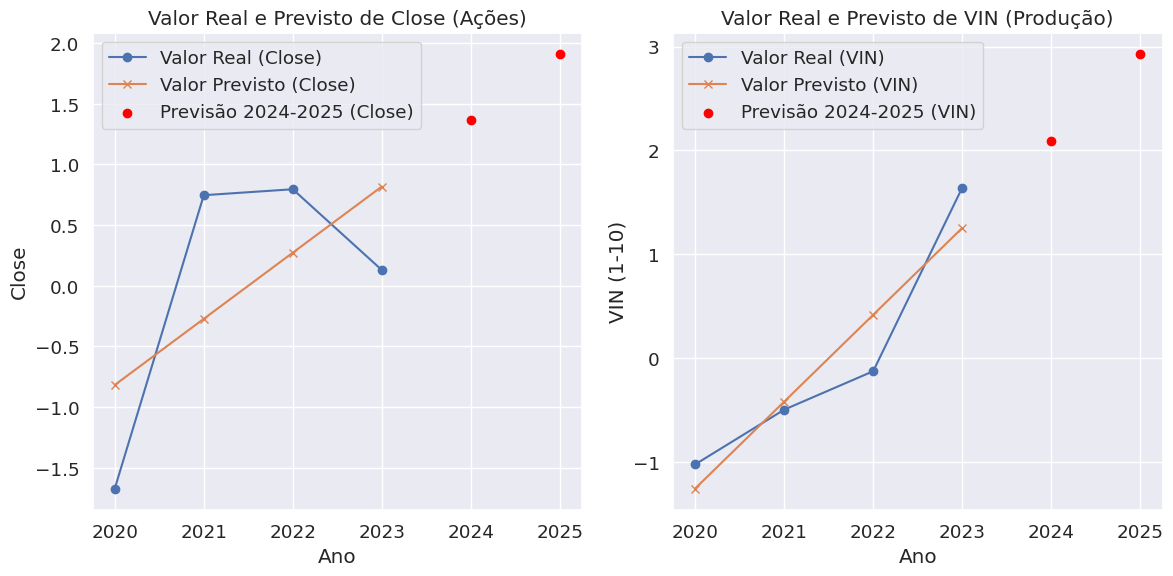

   Model Year  Previsão VIN (1-10)  Previsão Close
0        2024             2.090181        1.362940
1        2025             2.926254        1.908116


In [327]:
# Separando as variáveis independentes e dependentes
X = cars_and_stocks_1[['Model Year']]
y_vin = cars_and_stocks_1['VIN (1-10)']
y_close = cars_and_stocks_1['Close']
# y_sells = cars_and_stocks_1['Base MSRP']

# Criando e treinando o modelo de regressão para "VIN (1-10)"
model_vin = LinearRegression()
model_vin.fit(X, y_vin)

# Criando e treinando o modelo de regressão para "Close"
model_close = LinearRegression()
model_close.fit(X, y_close)

# Criando e treinando o modelo de regressão para 'Base MSRP'
# model_sells = LinearRegression()
# model_sells.fit(X, y_sells)

# Prevendo os valores de 2020 a 2023 para os modelos
predicted_vin = model_vin.predict(X)
predicted_close = model_close.predict(X)
# predicted_sells = model_sells.predict(X)

# Prevendo para os anos de 2024 e 2025
future_years = np.array([[2024], [2025]])
future_pred_vin = model_vin.predict(future_years)
future_pred_close = model_close.predict(future_years)
# future_pred_sells = model_sells.predict(future_years)

# Plotando o valor real e previsto ano a ano
plt.figure(figsize=(12, 6))

# Gráfico de Close
plt.subplot(1, 2, 1)
plt.plot(cars_and_stocks_1['Model Year'], cars_and_stocks_1['Close'], label='Valor Real (Close)', marker='o')
plt.plot(cars_and_stocks_1['Model Year'], predicted_close, label='Valor Previsto (Close)', marker='x')
plt.scatter(future_years, future_pred_close, color='red', label='Previsão 2024-2025 (Close)')
plt.xlabel('Ano')
plt.ylabel('Close')
plt.title('Valor Real e Previsto de Close (Ações)')
plt.legend()

# Gráfico de VIN (1-10)
plt.subplot(1, 2, 2)
plt.plot(cars_and_stocks_1['Model Year'], cars_and_stocks_1['VIN (1-10)'], label='Valor Real (VIN)', marker='o')
plt.plot(cars_and_stocks_1['Model Year'], predicted_vin, label='Valor Previsto (VIN)', marker='x')
plt.scatter(future_years, future_pred_vin, color='red', label='Previsão 2024-2025 (VIN)')
plt.xlabel('Ano')
plt.ylabel('VIN (1-10)')
plt.title('Valor Real e Previsto de VIN (Produção)')
plt.legend()

# Gráfico de Sells
# plt.subplot(1, 2, 2)
# plt.plot(cars_and_stocks_1['Model Year'], cars_and_stocks_1['Base MSRP'], label='Vendas Projetadas', marker='o')
# plt.plot(cars_and_stocks_1['Model Year'], predicted_sells, label='Valor Previsto Vendas', marker='x')
# plt.scatter(future_years[:, 0], future_pred_sells, color='red', label='Previsão 2024-2025 (Sells)')
# plt.xlabel('Ano')
# plt.ylabel('Sells')
# plt.title('Valor Real e Previsto de Vendas (Ações)')
# plt.legend()

plt.tight_layout()
plt.show()

# Exibindo os valores previstos para 2024 e 2025
predictions = pd.DataFrame({
    'Model Year': [2024, 2025],
    'Previsão VIN (1-10)': future_pred_vin,
    'Previsão Close': future_pred_close
    })

print(predictions)

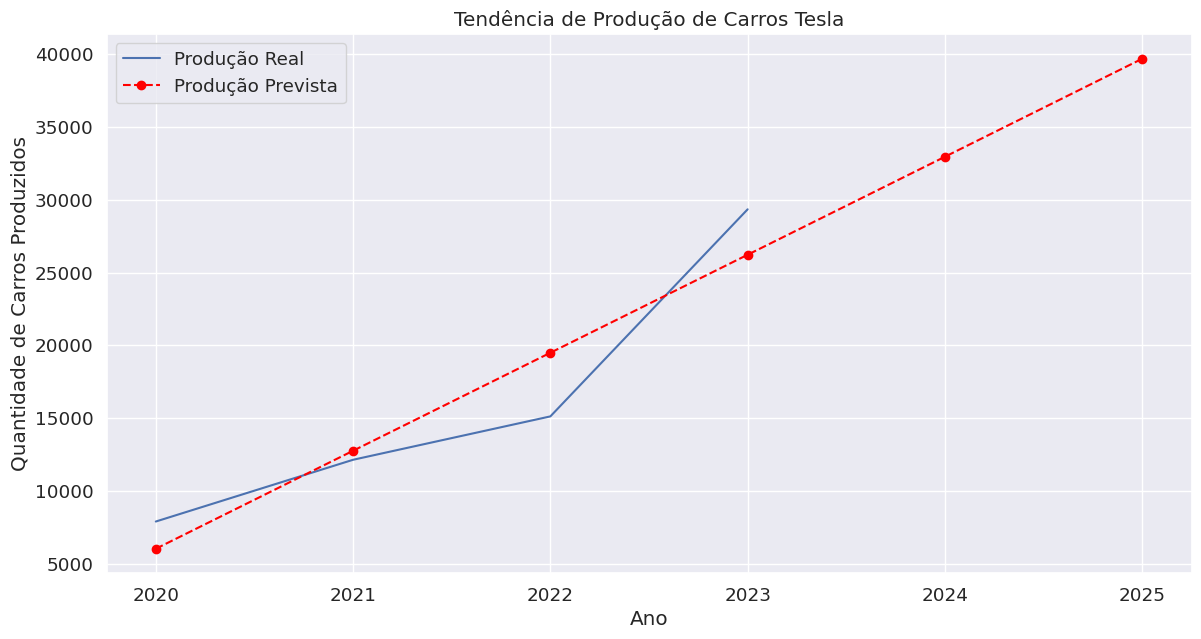

Tendência de produção para 2024 e 2025: 32959 e 39691 carros, respectivamente


In [328]:
# tendências para produção de carros em 2024 e 2025 (dados não padronizados)

# Filtrar os dados para incluir apenas os anos de 2020 a 2023
tesla_cars_filtered = tesla_cars[tesla_cars['Model Year'].isin(anos_analisados)]

# Agrupar os dados por ano e contar a quantidade de carros
tesla_cars_by_year = tesla_cars_filtered.groupby('Model Year')['VIN (1-10)'].count()

# Criar um modelo de regressão linear

X = tesla_cars_by_year.index.values.reshape(-1, 1)
y = tesla_cars_by_year.values
model = LinearRegression()
model.fit(X, y)

# Prever a produção de carros em 2025
future_year = np.array([[2020], [2021], [2022], [2023], [2024], [2025]])
predicted_production = model.predict(future_year)

# Plotar o gráfico de tendências
plt.plot(tesla_cars_by_year.index, tesla_cars_by_year.values, label='Produção Real')
plt.plot(future_year, predicted_production, marker='o', linestyle='--', color='red', label='Produção Prevista')
plt.title('Tendência de Produção de Carros Tesla')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Carros Produzidos')
plt.legend()
plt.show()

print(f"Tendência de produção para 2024 e 2025: {int(predicted_production[4])} e {int(predicted_production[5])} carros, respectivamente")


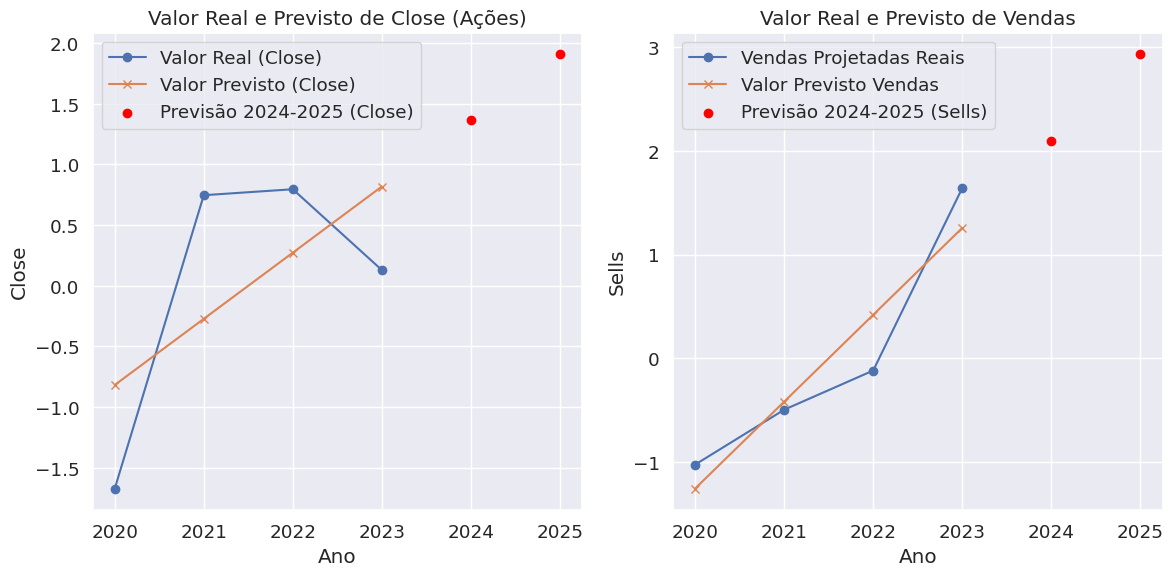

   Model Year  Previsão Vendas  Previsão Close
0        2024         2.093090        1.362940
1        2025         2.930325        1.908116


In [329]:
# Separando as variáveis independentes e dependentes
X = sells_and_stocks_1[['Model Year']]
y_sells = sells_and_stocks_1['Base MSRP']
y_close = sells_and_stocks_1['Close']

# Criando e treinando o modelo de regressão para "Close"
model_close = LinearRegression()
model_close.fit(X, y_close)

# Criando e treinando o modelo de regressão para 'Base MSRP'
model_sells = LinearRegression()
model_sells.fit(X, y_sells)

# Prevendo os valores de 2020 a 2023 para os modelos
predicted_close = model_close.predict(X)
predicted_sells = model_sells.predict(X)

# Prevendo para os anos de 2024 e 2025
future_years = np.array([[2024], [2025]])
future_pred_close = model_close.predict(future_years)
future_pred_sells = model_sells.predict(future_years)

# Plotando o valor real e previsto ano a ano
plt.figure(figsize=(12, 6))

# Gráfico de Close
plt.subplot(1, 2, 1)
plt.plot(sells_and_stocks_1['Model Year'], sells_and_stocks_1['Close'], label='Valor Real (Close)', marker='o')
plt.plot(sells_and_stocks_1['Model Year'], predicted_close, label='Valor Previsto (Close)', marker='x')
plt.scatter(future_years, future_pred_close, color='red', label='Previsão 2024-2025 (Close)')
plt.xlabel('Ano')
plt.ylabel('Close')
plt.title('Valor Real e Previsto de Close (Ações)')
plt.legend()

# Gráfico de Sells
plt.subplot(1, 2, 2)
plt.plot(sells_and_stocks_1['Model Year'], sells_and_stocks_1['Base MSRP'], label='Vendas Projetadas Reais', marker='o')
plt.plot(sells_and_stocks_1['Model Year'], predicted_sells, label='Valor Previsto Vendas', marker='x')
plt.scatter(future_years, future_pred_sells, color='red', label='Previsão 2024-2025 (Sells)')
plt.xlabel('Ano')
plt.ylabel('Sells')
plt.title('Valor Real e Previsto de Vendas')
plt.legend()

plt.tight_layout()
plt.show()

# Exibindo os valores previstos para 2024 e 2025
predictions = pd.DataFrame({
    'Model Year': [2024, 2025],
    'Previsão Vendas': future_pred_sells,
    'Previsão Close': future_pred_close
    })

print(predictions)

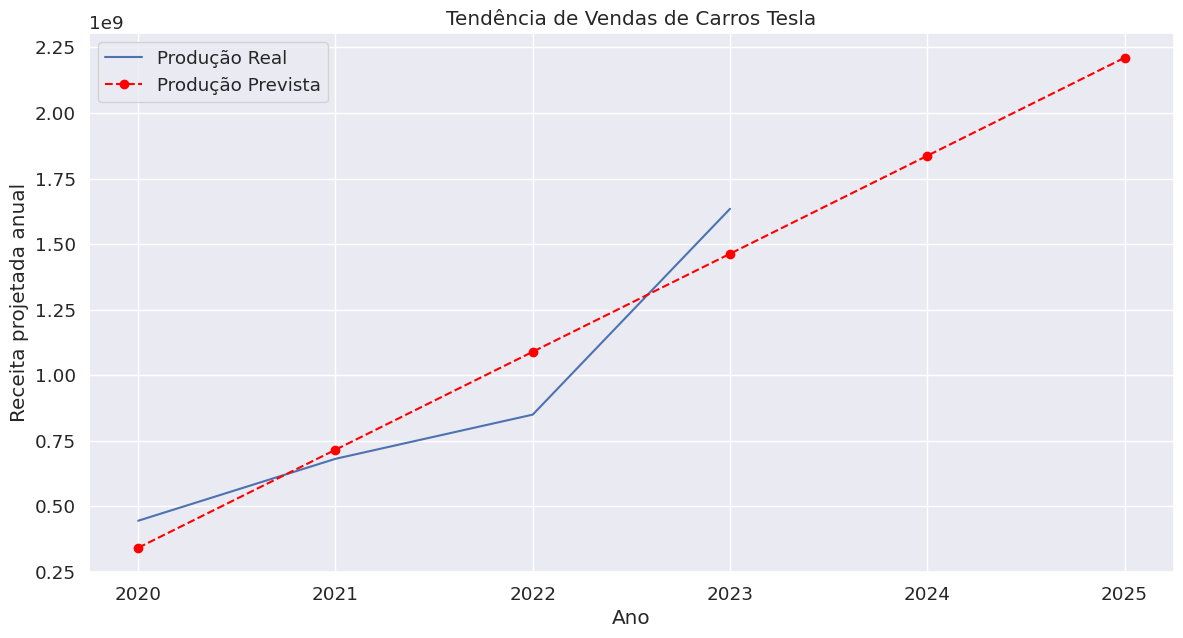

Tendência de vendas para 2024 e 2025: 1836756350 e 2210429637 de dólares, respectivamente


In [330]:
# tendência de vendas em 2024 e 2025 (dados não padronizados)

# Filtrar os dados para incluir apenas os anos de 2020 a 2023
tesla_cars_filtered = tesla_cars[tesla_cars['Model Year'].isin(anos_analisados)]

# Agrupar os dados por ano
sells_tesla_cars_by_year = tesla_cars_filtered.groupby('Model Year')['Base MSRP'].sum()

# Criar um modelo de regressão linear

X = sells_tesla_cars_by_year.index.values.reshape(-1, 1)
y = sells_tesla_cars_by_year.values
model = LinearRegression()
model.fit(X, y)

# Prever a receita em 2024 e 2025
future_year = np.array([[2020], [2021], [2022], [2023], [2024], [2025]])
predicted_sells = model.predict(future_year)

# Plotar o gráfico de tendências
plt.plot(sells_tesla_cars_by_year.index, sells_tesla_cars_by_year.values, label='Produção Real')
plt.plot(future_year, predicted_sells, marker='o', linestyle='--', color='red', label='Produção Prevista')
plt.title('Tendência de Vendas de Carros Tesla')
plt.xlabel('Ano')
plt.ylabel('Receita projetada anual')
plt.legend()
plt.show()

print(f"Tendência de vendas para 2024 e 2025: {int(predicted_sells[4])} e {int(predicted_sells[5])} de dólares, respectivamente")

# **Conclusões e Aprendizado**

Os datasets utilizados não continham muitos dados faltantes, mas poderiam melhorar a qualidade da informação caso, no exemplo dataset de carros elétricos, tivesse um valor aproximado de carros vendidos em cada ano, ou, ainda, se o dataset de ações tivesse um período maior de cobertura. Muito embora tenhamos utilizado o preço sugerido de vendas, ainda não é o ideal, pois supomos que todos os carros foram de fato vendidos e por tal preço.

Como esperado, há uma forte conexão entre a capacidade produtiva da empresa e o valor de suas ações no mercado. Entretanto, nem de longe o modelo conseguiria prever os valores dessas ações, usando como base apenas a essa capacidade operacional, pois há diversos fatores externos e internos que realmente impactam nesses valores.

O que o modelo nos mostra é que há uma correlação positiva entre esses dados e é esperado que a produção suba, e que os valores das ações acompanhem esse crescimento, bem como a receita projetada anual.